This notebook covers Bayesian probability updating and Mult-Armed Bandits. We introduce the Beta distribution and show how it evolves as you apply a Bayesian updating procedure to it. We then show how this illustrated concept is used in a Reinforcement Learning technique called the Multi-Armed Bandit (MAB). We present a MAB Class that simulates a MAB in practice and provide helper functions to visually explore their progress. 

<i>More description to come...</i>

In [72]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

## Bayesian Updating

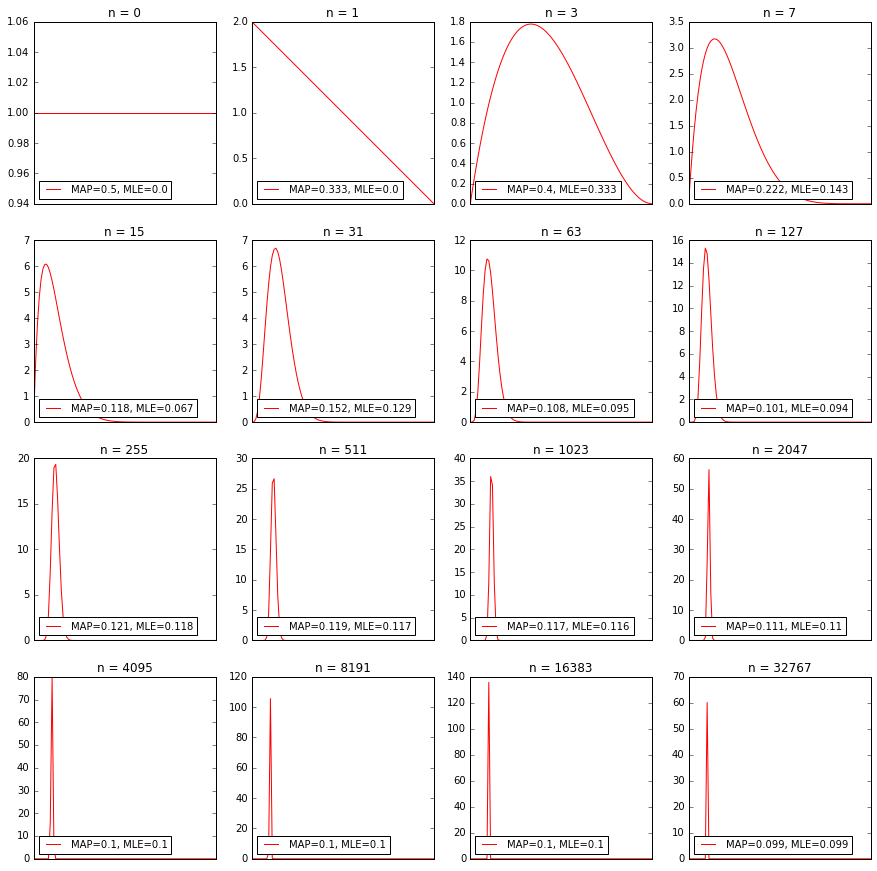

In [109]:
from scipy.stats import beta

def getBetaPDF(a, b):
    '''
    Returns a pdf of a specified beta distribution
    '''
    #x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    x = np.linspace(0.001, 0.999, 100)
    return beta.pdf(x, a, b)


##Simulate a Bayesian updating process and visualize the Beta


p = 0.1
k = 4
alpha_prior = 1
beta_prior = 1
s_total = 0
n_total = 0

ns = [0] + [2**i for i in range(k**2 - 1)]

fig = plt.figure(figsize = (15, 15))
x = np.linspace(0.001, 0.999, 100)

for i, new_trials in enumerate(ns):

    
    s_new = sum((np.random.random(new_trials) < p))
    
    alpha_prior += s_new
    s_total += s_new
    n_total += new_trials
    beta_prior += (new_trials - s_new) 
    
    
    beta_pdf = sp.stats.beta.pdf(x, alpha_prior, beta_prior)
    
    ax = fig.add_subplot(k, k, i + 1)
    p_map = round((alpha_prior) / (float(beta_prior) + alpha_prior), 3)
    p_mle = round(s_total / (n_total + 0.0000000001), 3)

    plt.plot(x, beta_pdf, 'r', label = 'MAP={}, MLE={}'.format(p_map, p_mle))
    plt.legend(loc = 3, fontsize = 10)
    ax.axes.get_xaxis().set_visible(False)
    plt.title('n = {}'.format(n_total))

    



## The MAB Simulator

In [1]:
def getProb(n, s):
    
    if n > 0:
        return s / float(n)
    else:
        return 0.0

def getUCB(n, s):
    '''
    Assumes 95% UCB so Z = 1.96
    '''
    
    #Need to address the cold start problem by randomly selecting
    if n > 0 and s > 0:
        
        p = getProb(n, s)
        return p + 1.96 * np.sqrt(p * (1 - p) / n)

    else:
        return np.random.beta(1, 1)

class mabSimulator(object):
    

    def __init__(self, p_truths, draws, alp = 1, bet = 1, 
                 strategy = 'Thompson', snapshot = 10):
        '''
        p_truths = an n element list where each element is in [0, 1]
        alpha and beta = priors for the beta distribution
        draws = number of draws for the multi-armed bandit
        strategy = one of Thompson, UCB
        snapshot = take a snapshot after k draws
        '''

        self.p_truths = p_truths
        self.cumresults = {i:[bet, alp] for i in range(len(p_truths))}
        self.results_snapshot = {'policy':[],
                                'round': [],
                                'draws': [],
                                'successes': [],
                                'probs': [],
                                'betaProbs': []}
        
        self.draws = draws
        self.snapshot = snapshot
        self.beta_prior = bet
        self.alpha_prior = alp
        self.strategy = strategy
        
    def _thompsonSamp(self):
        '''
        Draw from Beta(alpha + suc, beta + n - suc)
        '''
        beta_draws = [np.random.beta(x[1][1], x[1][0]) 
                    for x in list(self.cumresults.items())]
        
        return self._chooseBestPolicy(beta_draws)
    
    def _epsGreedy(self):
        '''
        Draw from an epsilon greedy algorithm
        '''
        epsilon = 0.2

        probs = [getProb(x[1][0] + x[1][1] - self.beta_prior, x[1][1] - self.alpha_prior) 
                    for x in list(self.cumresults.items())]
        
        #Add a small tie breaker
        probs = [p + np.random.random() / 100000 for p in probs]
        
        best_i = _chooseBestPolicy(probs)
        
        if np.random.random() > epsilon:
            return best_i
        
        else:
            leftover = [i for i in range(len(probs)) if i != best_i]
            return leftover[np.random.randint(0, len(leftover))]

        
    def _ucbSamp(self):
        '''
        Chooses the policy with the highest upper confidence band
        '''
        #For UCB we want to remove the prior from our results
        ucbs = [getUCB(x[1][0] + x[1][1] - self.beta_prior, x[1][1] - self.alpha_prior) 
                    for x in list(self.cumresults.items())]
        
        return self._chooseBestPolicy(ucbs)

    def _chooseBestPolicy(self, scores):

        max_policy = -1
        max_score = 0

        for i, score in enumerate(scores):
            
            if score > max_score:
                
                max_score = score
                max_policy = i
                
        return max_policy        
        
    def _singleDraw(self):
        '''
        1. Chooses a policy based on sampling strategy
        2. Receives an input result (based on truth)
        3. Updates cumresults
        '''
        if self.strategy == 'Thompson':
            
            policy = self._thompsonSamp()
            
        else if self.strategy = 'UCB':
            policy = self._ucbSamp()
            
        else:
            policy = self._epsGreedy()
            
        #Now interact with the world to get a result (i.e., random number generator)
        success = int(np.random.random() < self.p_truths[policy])
        self.cumresults[policy][0] += 1 - success #Increment the total failures
        self.cumresults[policy][1] += success #Increment the total successes
        
        
    def runSimulation(self):
        '''
        wrapper method that runs the full simulation
        '''
        snapshot_counter = 0
        self._getSnapshot(0)
        
        for i in range(1, self.draws + 1):
            
            self._singleDraw()
            snapshot_counter += 1
            
            if snapshot_counter == self.snapshot:
                self._getSnapshot(i)
                snapshot_counter = 0
        
        
    def _getSnapshot(self, i):
        
        n = len(self.p_truths)
        self.results_snapshot['policy'] += range(n)
        self.results_snapshot['round'] += [i for k in range(n)]
        
        
        alphas = np.array([x[1][1] for x in list(self.cumresults.items())])
        betas = np.array([x[1][0] for x in list(self.cumresults.items())])
        
        draws = alphas + betas - self.beta_prior - self.alpha_prior
        successes = alphas - self.alpha_prior
        
        self.results_snapshot['draws'] += list(draws)
        self.results_snapshot['successes'] += list(successes)
        self.results_snapshot['probs'] += list(map(getProb, draws, successes))
        self.results_snapshot['betaProbs'] += list(map(getProb, alphas + betas, alphas))

        
        
        

In [187]:
def r():
    return np.random.random()

def plotMabSim(mabsim, colors = None):

    res = pd.DataFrame(mabsim.results_snapshot)
    policies = list(set(res['policy'].values))

    if colors == None:
        colors = [(r(), r(), r()) for i in policies]
    
    fig = plt.figure(figsize = (15, 8))
    plt.title('MAB Sequences Over Time')

    ax1 = fig.add_subplot(211)
    for i in policies:
        res_i = res[(res.policy == i)]
        plt.plot(res_i['round'], res_i.betaProbs, color = colors[i], markersize = 4)
        ax1.set_ylim([0.05, 0.55])
        plt.plot(res_i['round'], mabsim.p_truths[i] * np.ones(len(res_i['round'])), 'g--', markersize = 2)
    
    ax2 = fig.add_subplot(212)
    for i in policies:
        res_i = res[(res.policy == i)]
        plt.plot(res_i['round'], res_i.draws, color = colors[i])
        
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Number Draws')
    ax1.set_ylabel('MAP Prob Estimate')


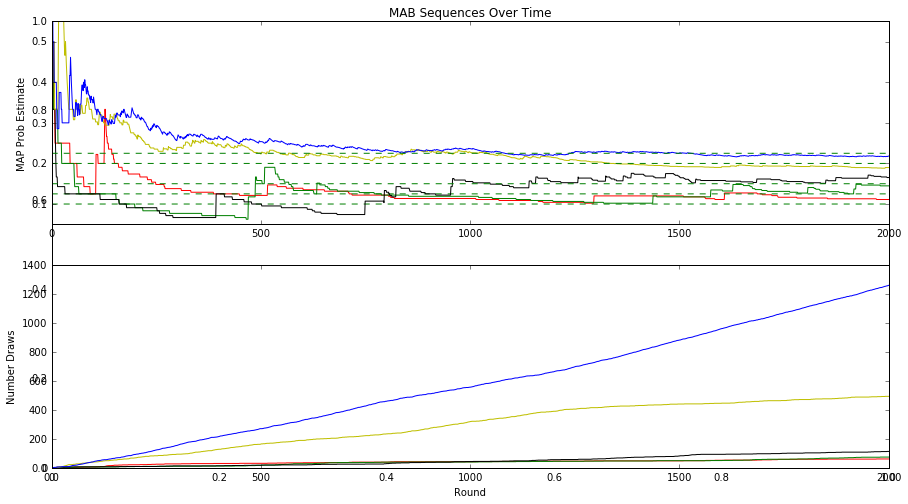

In [188]:
colors = ['r', 'g', 'k', 'y', 'b']
ps = [0.1, 0.125, 0.15, 0.2, 0.225]

mabsim_ts = mabSimulator(ps, 2000, snapshot = 1, strategy = 'Thompson')
mabsim_ts.runSimulation()
plotMabSim(mabsim_ts, colors)

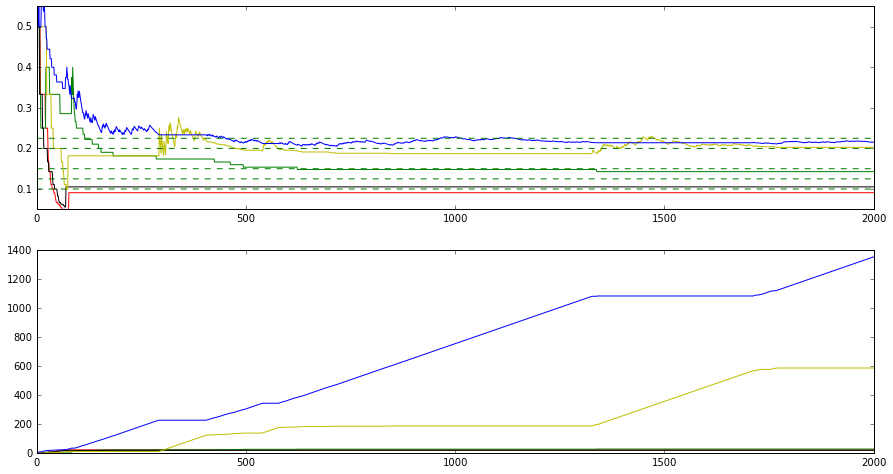

In [139]:
colors = ['r', 'g', 'k', 'y', 'b']
ps = [0.1, 0.125, 0.15, 0.2, 0.225]

mabsim_ucb = mabSimulator(ps, 2000, snapshot = 1, strategy = 'UCB')
mabsim_ucb.runSimulation()
plotMabSim(mabsim_ucb, colors)

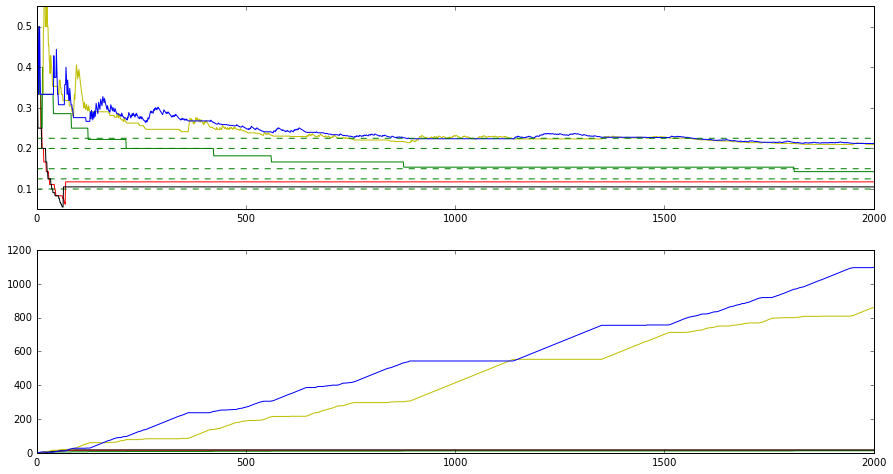

In [138]:
colors = ['r', 'g', 'k', 'y', 'b']
ps = [0.1, 0.125, 0.15, 0.2, 0.225]

mabsim_eps = mabSimulator(ps, 2000, snapshot = 1, strategy = 'EPS')
mabsim_eps.runSimulation()
plotMabSim(mabsim_eps, colors)

In [164]:

def multipleSims(strategy, sims):
    '''
    Run multiple simulations and get average payout across simulations
    '''
    df_list = []
    for i in range(sims):
        mabsim2 = mabSimulator(ps, 5000, snapshot = 20, strategy = strategy)
        mabsim2.runSimulation()
        a = pd.DataFrame(mabsim2.results_snapshot)
        df_list.append(a[['round', 'successes','draws']].groupby(['round']).sum().reset_index())
        
    return pd.concat(df_list).groupby(['round']).sum().reset_index()

In [190]:
ts = multipleSims('thompson', 100)
ucb = multipleSims('UCB', 100)
eps = multipleSims('eps', 100)

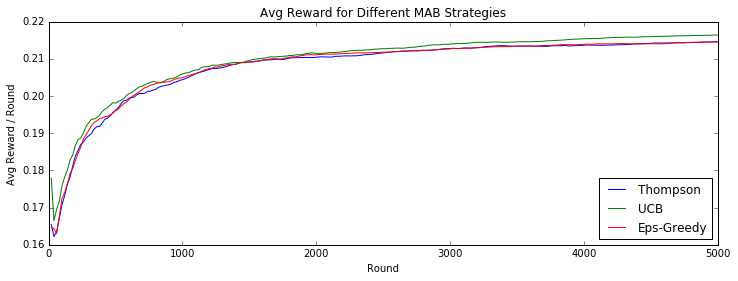

In [189]:
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(111)
plt.plot(ts['round'], ts['successes'] / ts['draws'], label = 'Thompson')
plt.plot(ucb['round'], ucb['successes'] / ucb['draws'], label = 'UCB')
plt.plot(eps['round'], eps['successes'] / eps['draws'], label = 'Eps-Greedy')
plt.title('Avg Reward for Different MAB Strategies')
ax.set_xlabel('Round')
ax.set_ylabel('Avg Reward / Round')
plt.legend(loc = 4)